In [10]:
import os 
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import cv2
from imgaug import augmenters as iaa

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
import random

path = 'D:\simulator\data'

# 1.导入数据

In [11]:
def getName(filePath):
    return filePath.split('\\')[-1]
 
# import data
def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(path, 'driving_log.csv'), names = columns)
    #### REMOVE FILE PATH AND GET ONLY FILE NAME
    #print(getName(data['center'][0]))
    data['Center']=data['Center'].apply(getName)
    #print(data.head())
    print('Total Images Imported',data.shape[0])
    return data

# 2.平衡数据

In [12]:
def balanceData(data,display=True):
    nBin = 31
    samplesPerBin = 500
    hist, bins = np.histogram(data['Steering'], nBin)
    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()
    #remove data
    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)
 
    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))
    if display:
        hist, _ = np.histogram(data['Steering'], (nBin))
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

# 3.加载数据

In [13]:
def load_data(data):
    image_list=[]
    steering_list=[]
    for i in range(len(data)):
        row_data=data.iloc[i]
        image_list.append(row_data.iloc[0])
        steering_list.append(row_data.iloc[3])
    return np.asarray(image_list),np.asarray(steering_list,dtype=np.float32)

# 4.图像变换

In [14]:
def augment_image(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering
    return img, steering

In [15]:
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [16]:
def batch_gen(imagesPath, steeringList, batchSize, trainFlag):
    while True:
        imgBatch = []
        steeringBatch = []

        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img,steering = augment_image(path+"/IMG/"+imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(path+"/IMG/"+imagesPath[index])
                steering = steeringList[index]
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        yield (np.asarray(imgBatch),np.asarray(steeringBatch))

# 5.模型定义

In [17]:
def createModel():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(50, activation = 'elu'))
    model.add(Dense(10, activation = 'elu'))
    model.add(Dense(1))

    model.compile(Adam(lr=0.0001),loss='mse')
    return model

# 程序入口

In [18]:
data = importDataInfo(path)

#balance
balanceData(data,False)

#load data
iamge_path,sterring_list=load_data(data)

#split
xTrain, xVal, yTrain, yVal = train_test_split(iamge_path, sterring_list, test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

model = createModel()
# model.summary()

history=model.fit(batch_gen(xTrain,yTrain,100,True),steps_per_epoch=300,epochs=10,
         validation_data=batch_gen(xVal,yVal,100,False),validation_steps=200)

model.save('model.h5')

Total Images Imported 4828
Removed Images: 3188
Remaining Images: 1640
Total Training Images:  1312
Total Validation Images:  328


D:\anaconda\envs\tensorflow-39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
300/300 [==============================] - 109s 362ms/step - loss: 0.0547 - val_loss: 0.0271
Epoch 2/10
300/300 [==============================] - 101s 336ms/step - loss: 0.0441 - val_loss: 0.0262
Epoch 3/10
300/300 [==============================] - 101s 336ms/step - loss: 0.0422 - val_loss: 0.0258
Epoch 4/10
300/300 [==============================] - 122s 408ms/step - loss: 0.0401 - val_loss: 0.0237
Epoch 5/10
300/300 [==============================] - 115s 383ms/step - loss: 0.0380 - val_loss: 0.0230
Epoch 6/10
300/300 [==============================] - 109s 365ms/step - loss: 0.0353 - val_loss: 0.0228
Epoch 7/10
300/300 [==============================] - 105s 350ms/step - loss: 0.0340 - val_loss: 0.0228
Epoch 8/10
300/300 [==============================] - 103s 344ms/step - loss: 0.0332 - val_loss: 0.0226
Epoch 9/10
300/300 [==============================] - 101s 338ms/step - loss: 0.0319 - val_loss: 0.0243
Epoch 10/10
300/300 [==============================] - 102s 339m

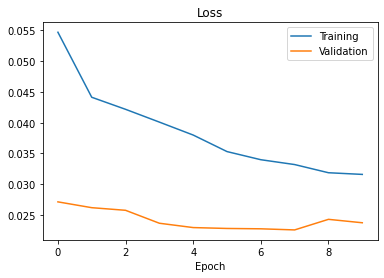

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()